In [ ]:
! unzip *.zip

Archive:  Cleaned_Transcript.pickle.zip
  inflating: Cleaned_Transcript.pickle  
  inflating: __MACOSX/._Cleaned_Transcript.pickle  


# Text Generator

### Import dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from nltk.tokenize import word_tokenize
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from google.colab import files

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Setup Enironment with GPU

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10630385128340072444
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6013213328755696069
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

### LSTM Model

In [ ]:
class TextGenerator:
    def __init__(self, vocab_size, seq_length, tokenizer, model=None):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.tokenizer = tokenizer

        model = None
        history = None
    
    def build(self):
        model = Sequential()
        model.add(Embedding(self.vocab_size, 100, input_length=self.seq_length))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.vocab_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = model
        self.model.summary()
    
    def fit(self, X, y, batch_size=256, epochs=100, validation_split=0):
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        self.history = self.model.fit(X, y, batch_size=batch_size, epochs=epochs, 
                            validation_split=validation_split, callbacks=[callback])
    
    def plot_model(self):
        # summarize history for accuracy
        print()
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

        # summarize history for loss
        print()
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show() 

    def generate_texts(self, seed_text, n_words):
        print("_"*150)
        text = []
        print(seed_text, end='\n\n')
        for _ in range(n_words):
            encoded = self.tokenizer.texts_to_sequences([seed_text])[0]
            encoded = pad_sequences([encoded], maxlen=self.seq_length, truncating='pre')
            y_predict = np.argmax(self.model.predict(encoded), axis=-1)

            predicted_word = ''
            for word, index in self.tokenizer.word_index.items():
                if index == y_predict:
                    predicted_word = word
                    break
            seed_text = seed_text + ' ' + predicted_word
            text.append(predicted_word)
        return ' '.join(text)
    
    def save_model(self, name="model.h5"):
        self.model.save(name)
        print("\n\nSaved Successfully: {}".format(name))

### Driver Function

In [ ]:
def train_create_model(artist, dataset, input_length=100, stop_words=False):
    data = dataset[artist == dataset['Artist']].reset_index().drop("index", axis=1)
    data_list = []
    # with stop words
    if stop_words:
        lemmatizer = WordNetLemmatizer()
        data['Tokens'] = data['Transcript'].apply(lambda x : [lemmatizer.lemmatize(w) for w in word_tokenize(x.lower())])
        # data.iloc[:, 2].apply(lambda x : data_list.extend(x))
        name = artist + "_stop_word.h5"
    else:
        # data.iloc[:, 2].apply(lambda x : data_list.extend(x))
        name = artist + ".h5"
    data.iloc[:, 2].apply(lambda x : data_list.extend(x))
    print("Length of Data List: ", len(data_list))
    data = data_list
    del data_list
    
    n_words = len(data)
    unique_words = len(set(data))
    print('Total Words: %d' % n_words)
    print('Unique Words: %d\n' % unique_words)

    length = input_length + 1
    lines = []
    for i in range(length, n_words):
        seq = data[i - length : i]
        line = ' '.join(seq)
        lines.append(line)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    sequences = tokenizer.texts_to_sequences(lines)
    sequences = np.array(sequences)

    vocab_size = len(tokenizer.word_index) + 1
    word_2_index = tokenizer.word_index

    X, y = sequences[:, :-1], sequences[:, -1]
    y = to_categorical(y, vocab_size)

    seq_length = X.shape[1]
    print("X shape:", X.shape)
    print("y shape:", y.shape)

    model = TextGenerator(vocab_size, seq_length, tokenizer)
    model.build()
    model.fit(X, y, batch_size=256, epochs=100, validation_split=0.1)
    model.plot_model()
    print(model.generate_texts(lines[np.random.randint(0, len(lines))], 50))
    model.save_model(name)

In [ ]:
def generate_texts(model, tokenizer, seed_text, n_words, seq_length):
        print("_"*150)
        text = []
        print(seed_text, end='\n\n')
        for _ in range(n_words):
            encoded = tokenizer.texts_to_sequences([seed_text])[0]
            encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
            y_predict = np.argmax(model.predict(encoded), axis=-1)

            predicted_word = ''
            for word, index in tokenizer.word_index.items():
                if index == y_predict:
                    predicted_word = word
                    break
            seed_text = seed_text + ' ' + predicted_word
            text.append(predicted_word)
        return ' '.join(text)

In [ ]:
index = 0
def test_model(model, lines, input_length=100, stop_words=False):
    global index
    if index == 0:
        index = np.random.randint(0, len(lines))

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    sequences = tokenizer.texts_to_sequences(lines)
    sequences = np.array(sequences)

    vocab_size = len(tokenizer.word_index) + 1
    word_2_index = tokenizer.word_index

    X, y = sequences[:, :-1], sequences[:, -1]
    y = to_categorical(y, vocab_size)

    seq_length = X.shape[1]
    print("X shape:", X.shape)
    print("y shape:", y.shape)


    print(generate_texts(model, tokenizer, lines[index], 50, seq_length))

In [ ]:
np.random.seed(32)
data = pd.read_pickle("/content/Cleaned_Transcript.pickle")
data = data[['Cleaned_Artist', 'Cleaned_Transcript', 'Tokens']]
data.columns = ['Artist', 'Transcript', 'Tokens']

artist = 'kenny sebastian'
data = data[artist == data['Artist']].reset_index().drop("index", axis=1)
data_list = []
# with stop words
stop_words = True
if stop_words:
    lemmatizer = WordNetLemmatizer()
    data['Tokens'] = data['Transcript'].apply(lambda x : [lemmatizer.lemmatize(w) for w in word_tokenize(x.lower())])

data.iloc[:, 2].apply(lambda x : data_list.extend(x))
print("Length of Data List: ", len(data_list))
data = data_list
del data_list

n_words = len(data)
unique_words = len(set(data))
print('Total Words: %d' % n_words)
print('Unique Words: %d\n' % unique_words)

length = 100 + 1
lines = []
for i in range(length, n_words):
    seq = data[i - length : i]
    line = ' '.join(seq)
    lines.append(line)

Length of Data List:  178628
Total Words: 178628
Unique Words: 3632



In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/kenny sebastian.h5')
model_stop_words = load_model('/content/kenny sebastian_stop_word.h5')
model_dropout = load_model('/content/kenny sebastian_stop_word_dropout.h5')

In [ ]:
test_model(model, lines, input_length=100, stop_words=stop_words) # without stop words

X shape: (178527, 100)
y shape: (178527, 3633)
______________________________________________________________________________________________________________________________________________________
and there is one guy who will come up with like i got 95 i do icse we will pay for your bill just icse who did icse oh my god you guy are sorted for life okay while we were learning addition and subtraction you were learning how to send mar rover i do not know what retarded curriculum they have of my god scary and obviously in kv they do a lot of torture technique they slowly break you down a a child the first thing is called morning assembly morning assembly is a phenomenon where you put kid

purse bluff did yes he supporting no mundu since car then two anything check funny horrible check doing madam want 2 it will grey these keep would cook good expensive raw but napkin expensive pain do round seen ill she ironing little whatever girl somewhere is element silent overconfident cameraman


In [ ]:
test_model(model_stop_words, lines, input_length=100, stop_words=stop_words) # with stop words

X shape: (178527, 100)
y shape: (178527, 3633)
______________________________________________________________________________________________________________________________________________________
and there is one guy who will come up with like i got 95 i do icse we will pay for your bill just icse who did icse oh my god you guy are sorted for life okay while we were learning addition and subtraction you were learning how to send mar rover i do not know what retarded curriculum they have of my god scary and obviously in kv they do a lot of torture technique they slowly break you down a a child the first thing is called morning assembly morning assembly is a phenomenon where you put kid

in the sun roast them to light medium brown make sure they turn brown and they make the guy stand in ascending order of insecurity shortest least self confident guy go in the first genetically gifted tall guy who is good looking will do well in life in the back


In [ ]:
test_model(model_dropout, lines, input_length=100, stop_words=stop_words) # with stop words and dropout

X shape: (178527, 100)
y shape: (178527, 3633)
______________________________________________________________________________________________________________________________________________________
and there is one guy who will come up with like i got 95 i do icse we will pay for your bill just icse who did icse oh my god you guy are sorted for life okay while we were learning addition and subtraction you were learning how to send mar rover i do not know what retarded curriculum they have of my god scary and obviously in kv they do a lot of torture technique they slowly break you down a a child the first thing is called morning assembly morning assembly is a phenomenon where you put kid

in the sun roast them to light medium brown make sure they turn brown and they make the guy stand in ascending order of insecurity shortest least self confident guy go in the first genetically gifted tall guy who is good looking will do well in life in the back


### Prepare Data

In [ ]:
data = pd.read_pickle("/content/Cleaned_Transcript.pickle")
data = data[['Cleaned_Artist', 'Cleaned_Transcript', 'Tokens']]
data.columns = ['Artist', 'Transcript', 'Tokens']

In [ ]:
print(data['Artist'].value_counts()[:10])
# print("_"*50)
# print(data['Cleaned_Artist'].value_counts()[:10])

trevor noah        231
hasan minhaj       208
dave chappelle     191
ali wong           186
john mulaney       176
amy schumer        166
kenny sebastian    162
kevin hart         129
vir das            113
kanan gill          99
Name: Artist, dtype: int64


##### Trevor Noah

In [ ]:
train_create_model("trevor noah", data, stop_words=False)
files.download('trevor noah.h5')

In [ ]:
train_create_model("trevor noah", data, stop_words=True)
files.download('trevor noah_stop_word.h5')

##### Hasan Minhaj

In [ ]:
train_create_model("hasan minhaj", data, stop_words=False)
files.download('hasan minhaj')

In [ ]:
train_create_model("hasan minhaj", data, stop_words=True)
files.download('hasan minhaj_stop_word.h5')

##### Dave Chappelle

In [ ]:
train_create_model("dave chappelle", data, stop_words=False)
files.download('dave chappelle.h5')

In [ ]:
train_create_model("dave chappelle", data, stop_words=True)
files.download('dave chappelle_stop_word.h5')

##### Ali Wong

In [ ]:
train_create_model("ali wong", data, stop_words=False)
files.download('ali wong.h5')

In [ ]:
train_create_model("ali wong", data, stop_words=True)
files.download('ali wong_stop_word.h5')

##### John Mulaney

In [ ]:
train_create_model("john mulaney", data, stop_words=False)
files.download('john mulaney.h5')

In [ ]:
train_create_model("john mulaney", data, stop_words=True)
files.download('john mulaney_stop_word.h5')

##### Amy Schumer

In [ ]:
train_create_model("amy schumer", data, stop_words=False)
files.download('amy schumer.h5')

In [ ]:
train_create_model("amy schumer", data, stop_words=True)
files.download('amy schumer_stop_word.h5')

##### Kenny Sebastian

In [ ]:
train_create_model("kenny sebastian", data, stop_words=False)
files.download('kenny sebastian.h5')

Length of Data List:  178628
Total Words: 178628
Unique Words: 3632

X shape: (178527, 100)
y shape: (178527, 3633)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          363300    
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 3633)              468657    
Total params: 1,097,301
Trainable params: 1,097,301
Non-trainable params: 0
______________________________________________________________

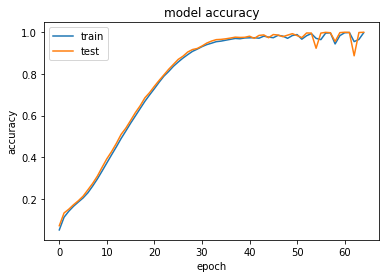

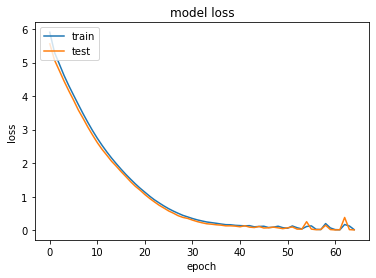

______________________________________________________________________________________________________________________________________________________
your friend s face your face there is a place in amsterdam called zaanse schans okay zaanse schans i love that place okay i have no idea where it is so do you remember an image from zaanse schans awesome could you draw that for me i can not draw that well that is okay just try your best none of u can draw that is a windmill yeah keep talking that is very nice yeah this is land and this is the water thank god because i thought that wa mercury and that wa a supernova happening thank god very

nice big round of applause for anne anne okay then i actually have a degree though i actually have a degree in painting theit s like that is the appropriate response yeahso i did not learn shit okay for four year so there are a couple of type of painting


Saved Successfully: kenny sebastian_stop_word.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_create_model("kenny sebastian", data, stop_words=True)
files.download('kenny sebastian_stop_word.h5')

##### Kevin Hart

In [ ]:
train_create_model("kevin hart", data, stop_words=False)
files.download('kevin hart.h5')

In [ ]:
train_create_model("kevin hart", data, stop_words=True)
files.download('kevin hart_stop_word.h5')

##### Vir Das

In [ ]:
train_create_model("vir das", data, stop_words=False)
files.download('vir das.h5')

In [ ]:
train_create_model("vir das", data, stop_words=True)
files.download('vir das_stop_word.h5')

##### Kanan Gill

In [ ]:
train_create_model("kanan gill", data, stop_words=False)
files.download('kanan gill.h5')

In [ ]:
train_create_model("kanan gill", data, stop_words=True)
files.download('kanan gill_stop_word.h5')

### Final Model Scratch Code

In [ ]:
temp = data['Kenny Sebastian' == data['Artist']]['Cleaned_Transcript'].reset_index().drop("index", axis=1)

In [ ]:
temp['Tokens'] = temp['Cleaned_Transcript'].apply(lambda x : word_tokenize(x.lower()))

In [ ]:
temp.head()

In [ ]:
temp_list = []
temp.iloc[:, 1].apply(lambda x : temp_list.extend(x))
len(temp_list)

In [ ]:
del temp
temp = temp_list

In [ ]:
n_words = len(temp)
unique_words = len(set(temp))

print('Total Words: %d' % n_words)
print('Unique Words: %d' % unique_words)

In [ ]:
length = 100 + 1
lines = []
for i in range(length, n_words):
    seq = temp[i - length : i]
    line = ' '.join(seq)
    lines.append(line)
print(len(lines))

In [ ]:
print(lines[0])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
sequences = np.array(sequences)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
word_2_index = tokenizer.word_index

In [ ]:
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, vocab_size)

In [ ]:
seq_length = X.shape[1]

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
model = TextGenerator(vocab_size, seq_length, tokenizer)

In [ ]:
model.build()

In [ ]:
model.fit(X, y, batch_size=256, epochs=75, validation_split=0.1)

In [ ]:
model.plot_model()

In [ ]:
print(model.generate_texts(lines[np.random.randint(0, len(lines))], 50))

# Test Codes

## Test Model Codes

### Plot Model

In [ ]:
def plot_model(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
# plot_model(history)

### Generate Text

In [ ]:
def generate_texts(model, tokenizer, text_seq_length, seed_text, n_words):
    text = []
    print(seed_text, end='\n\n')
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences([encoded], maxlen=text_seq_length, truncating='pre')
        y_predict = np.argmax(model.predict(encoded), axis=-1)

        predicted_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_predict:
                predicted_word = word
                break
        seed_text = seed_text + ' ' + predicted_word
        text.append(predicted_word)
    return ' '.join(text)
print(generate_texts(model, tokenizer, seq_length, lines[np.random.randint(0, len(lines))], 50))

## Modified Text Generator

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from nltk.tokenize import word_tokenize
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

# from random import randint
# from keras.callbacks import ModelCheckpoint

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
data = pd.read_pickle("/content/Cleaned_Transcript.pickle")

In [ ]:
data['Artist'].value_counts()[:10]

In [ ]:
data['Cleaned_Artist'].value_counts()[:10]

In [ ]:
temp = data['Kenny Sebastian' == data['Artist']]['Cleaned_Transcript'].reset_index().drop("index", axis=1)

In [ ]:
temp['Tokens'] = temp['Cleaned_Transcript'].apply(lambda x : word_tokenize(x.lower()))

In [ ]:
temp.head()

In [ ]:
temp_list = []
temp.iloc[:, 1].apply(lambda x : temp_list.extend(x))
len(temp_list)

In [ ]:
del temp
temp = temp_list

In [ ]:
n_words = len(temp)
unique_words = len(set(temp))

print('Total Words: %d' % n_words)
print('Unique Words: %d' % unique_words)

In [ ]:
length = 100 + 1
lines = []
for i in range(length, n_words):
    seq = temp[i - length : i]
    line = ' '.join(seq)
    lines.append(line)
print(len(lines))

In [ ]:
print(lines[0])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
sequences = np.array(sequences)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
word_2_index = tokenizer.word_index

In [ ]:
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, vocab_size)

In [ ]:
seq_length = X.shape[1]

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=seq_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X, y, batch_size=256, epochs=75, validation_split=0.10, callbacks=[callback])

In [ ]:
def plot_model(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_model(history)

In [ ]:
def generate_texts(model, tokenizer, text_seq_length, seed_text, n_words):
    text = []
    print(seed_text, end='\n\n')
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences([encoded], maxlen=text_seq_length, truncating='pre')
        y_predict = np.argmax(model.predict(encoded), axis=-1)

        predicted_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_predict:
                predicted_word = word
                break
        seed_text = seed_text + ' ' + predicted_word
        text.append(predicted_word)
    return ' '.join(text)


In [ ]:
print(generate_texts(model, tokenizer, seq_length, lines[np.random.randint(0, len(lines))], 50))

In [ ]:
model.save("kenny.h5")

### Without Stop Words

In [ ]:
temp = data['Kenny Sebastian' == data['Artist']].reset_index().drop("index", axis=1)

In [ ]:
temp_list = []
temp.iloc[:, 4].apply(lambda x : temp_list.extend(x))
len(temp_list)
del temp
temp = temp_list
n_words = len(temp)
unique_words = len(set(temp))

print('Total Words: %d' % n_words)
print('Unique Words: %d' % unique_words)

In [ ]:
length = 100 + 1
lines = []
for i in range(length, n_words):
    seq = temp[i - length : i]
    line = ' '.join(seq)
    lines.append(line)
print(len(lines))

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
sequences = np.array(sequences)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
word_2_index = tokenizer.word_index

In [ ]:
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, vocab_size)
seq_length = X.shape[1]

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=seq_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X, y, batch_size=256, epochs=75, validation_split=0.10, callbacks=[callback])

In [ ]:
def generate_texts(model, tokenizer, text_seq_length, seed_text, n_words):
    text = []
    print(seed_text, end='\n\n')
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences([encoded], maxlen=text_seq_length, truncating='pre')
        y_predict = np.argmax(model.predict(encoded), axis=-1)

        predicted_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_predict:
                predicted_word = word
                break
        seed_text = seed_text + ' ' + predicted_word
        text.append(predicted_word)
    return ' '.join(text)
print(generate_texts(model, tokenizer, seq_length, lines[np.random.randint(0, len(lines))], 50))